# 0. Install and Import dependencies

We will use the most advanced environment for RL-trading task - DI-engine/gym-anytrade. It's a part of DI-engine RL framework, which contains a lot of environments inside.

**Important notes: tensorflow==1.15.0 works only with Python 3.7 and below**

In [4]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym==0.19.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import gym
import gym_anytrading

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# 1. Load  Data 
https://www.marketwatch.com/investing/stock/gme/download-data?startDate=11/1/2019&endDate=03/12/2021

In [6]:
df = pd.read_csv('/content/STOCKS_GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [8]:
df.sort_values('Date', ascending=True, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100


In [9]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100


In [10]:
env = gym.make('stocks-v0', df=df, frame_bound=(5,250), window_size=5)

In [11]:
pd.DataFrame(env.signal_features)

,0,1
0,196.946945,0.000000
1,202.382385,5.435440
2,202.982986,0.600601
3,205.405411,2.422425
4,208.823822,3.418411
...,...,...
245,255.695694,2.747742
246,254.019012,-1.676682
247,254.239243,0.220231
248,249.434433,-4.804810


# 2. Build Environment

info {'total_reward': 58.53355399999995, 'total_profit': 0.49035653974069143, 'position': 0}


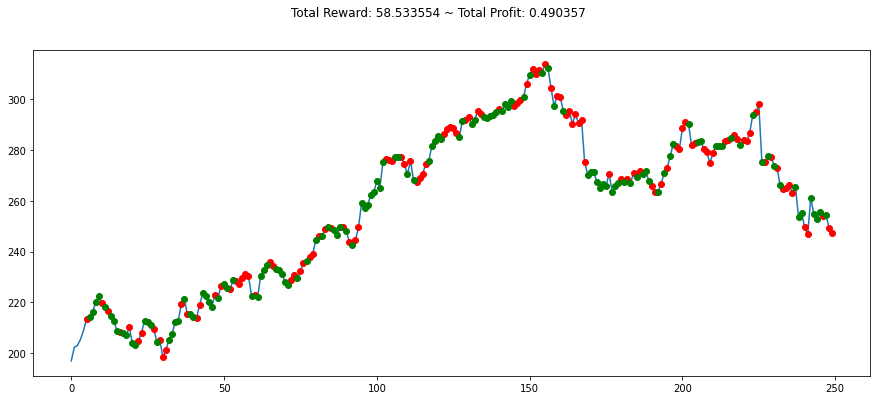

In [12]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# 2.1 Add Custom Indicators

## 2.1.1. Install and Import New Dependencies

In [13]:
!pip install finta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
from gym_anytrading.envs import StocksEnv
from finta import TA

## 2.1.2. Fix Volume Column

In [15]:
df['Volume'] = df['Volume'].apply(lambda x: float(f"{x}".replace(",", "")))

In [16]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

## 2.1.3. Calculate SMA, RSI and OBV

In [17]:
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

In [18]:
df.head(15)

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700.0,0.000000,0.000000,0.0
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700.0,0.000000,100.000000,6202700.0
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500.0,0.000000,100.000000,12265200.0
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200.0,0.000000,100.000000,17597400.0
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100.0,0.000000,100.000000,22888500.0
2009-06-01,209.574570,215.015015,209.474472,213.493500,213.493500,6638100.0,0.000000,100.000000,29526600.0
2009-06-02,213.338333,215.195190,211.911911,214.414413,214.414413,5241900.0,0.000000,100.000000,34768500.0
2009-06-03,213.213211,216.446442,212.212219,216.041046,216.041046,7058500.0,0.000000,100.000000,41827000.0
2009-06-04,217.867874,220.840836,217.467468,220.360367,220.360367,7268900.0,0.000000,100.000000,49095900.0


## 2.1.4. Create New Environments

In [19]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [20]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,50))

In [21]:
pd.DataFrame(env2.signal_features)

,0,1,2,3,4
0,196.196198,3433700.0,0.000000,0.000000,0.0
1,195.195190,6202700.0,0.000000,100.000000,6202700.0
2,202.607605,6062500.0,0.000000,100.000000,12265200.0
3,202.507507,5332200.0,0.000000,100.000000,17597400.0
4,205.555557,5291100.0,0.000000,100.000000,22888500.0
5,209.474472,6638100.0,0.000000,100.000000,29526600.0
6,211.911911,5241900.0,0.000000,100.000000,34768500.0
7,212.212219,7058500.0,0.000000,100.000000,41827000.0
8,217.467468,7268900.0,0.000000,100.000000,49095900.0
9,219.949951,7354200.0,0.000000,100.000000,56450100.0


In [22]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700.0,0.0,0.0,0.0
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700.0,0.0,100.0,6202700.0
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500.0,0.0,100.0,12265200.0
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200.0,0.0,100.0,17597400.0
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100.0,0.0,100.0,22888500.0


# 3. Build Environment and Train

In [23]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [24]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




Streaming output truncated to the last 5000 lines.
---------------------------------
| explained_variance | 0.996    |
| fps                | 345      |
| nupdates           | 137600   |
| policy_entropy     | 0.00111  |
| total_timesteps    | 688000   |
| value_loss         | 0.00025  |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 345      |
| nupdates           | 137700   |
| policy_entropy     | 0.000595 |
| total_timesteps    | 688500   |
| value_loss         | 0.00108  |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 345      |
| nupdates           | 137800   |
| policy_entropy     | 0.00252  |
| total_timesteps    | 689000   |
| value_loss         | 5.5e-05  |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 345      |
| nupdates           | 137900  

# 4. Evaluation

In [25]:
env = MyCustomEnv(df=df, window_size=12, frame_bound=(80,250))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 15.075025999999923, 'total_profit': 0.682803746991745, 'position': 0}


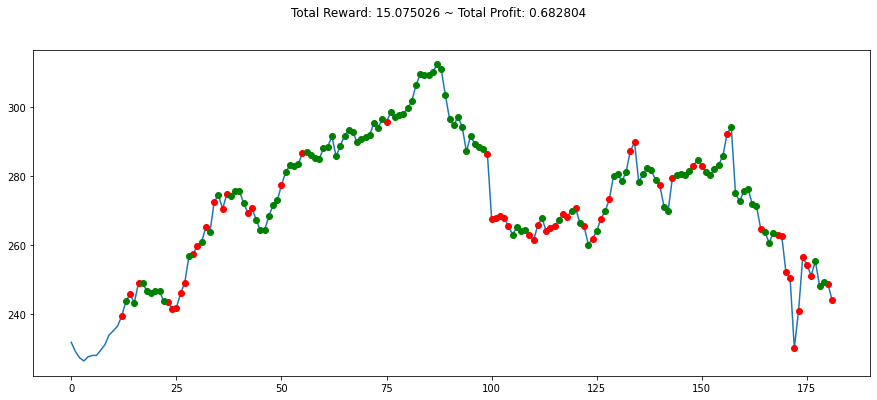

In [26]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()